### Install

In [ ]:
pip install tensorflow matplotlib numpy

In [14]:
!pip install timm

### Import Libery

In [15]:
import torch
import torchvision.transforms as transforms
import torchvision
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools
import timm

### GPU Check

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


### Data Transform

In [4]:
IMAGE_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

### Create Data

In [5]:
train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/emotion-detection-fer/train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/emotion-detection-fer/test", transform=transform)

In [6]:
print("Total train images:", len(train_dataset))
print("Class names:", train_dataset.classes)

print("Total test images:", len(test_dataset))
print("Class names:", test_dataset.classes)

Total train images: 28709
Class names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Total test images: 7178
Class names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


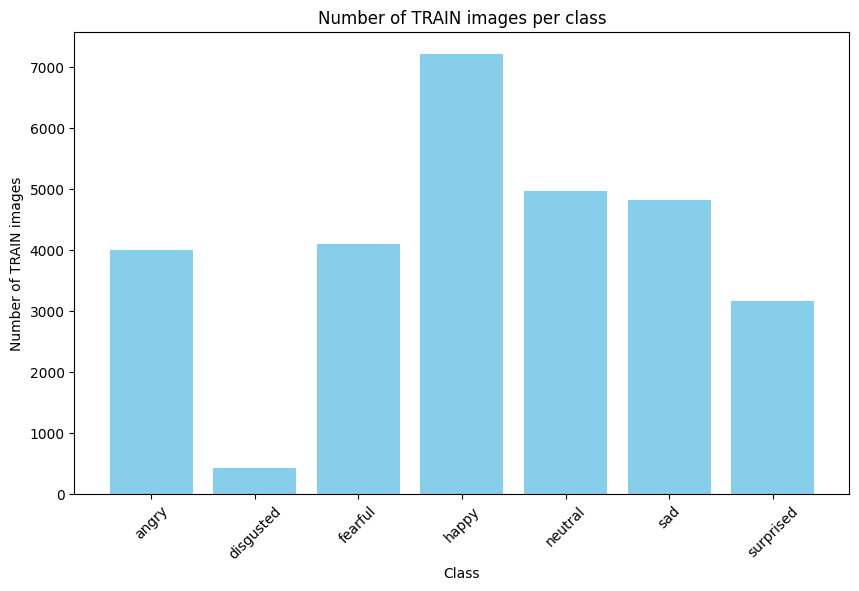

In [7]:
class_indices = [s[1] for s in train_dataset.samples]

counts = Counter(class_indices)

class_counts = [counts[i] for i in range(len(train_dataset.classes))]

plt.figure(figsize=(10, 6))
plt.bar(train_dataset.classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of TRAIN images')
plt.title('Number of TRAIN images per class')
plt.xticks(rotation=45)
plt.show()

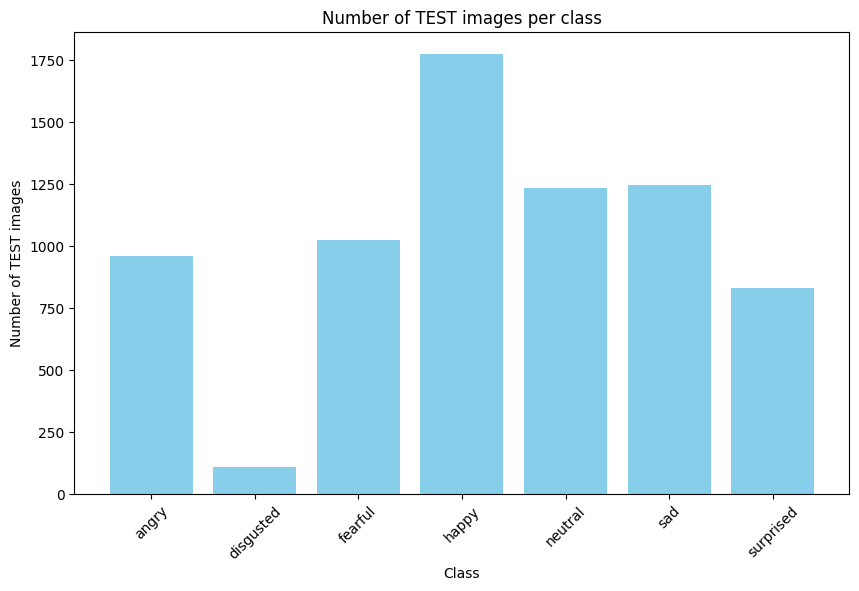

In [8]:
class_indices = [s[1] for s in test_dataset.samples]

counts = Counter(class_indices)

class_counts = [counts[i] for i in range(len(test_dataset.classes))]

plt.figure(figsize=(10, 6))
plt.bar(test_dataset.classes, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of TEST images')
plt.title('Number of TEST images per class')
plt.xticks(rotation=45)
plt.show()

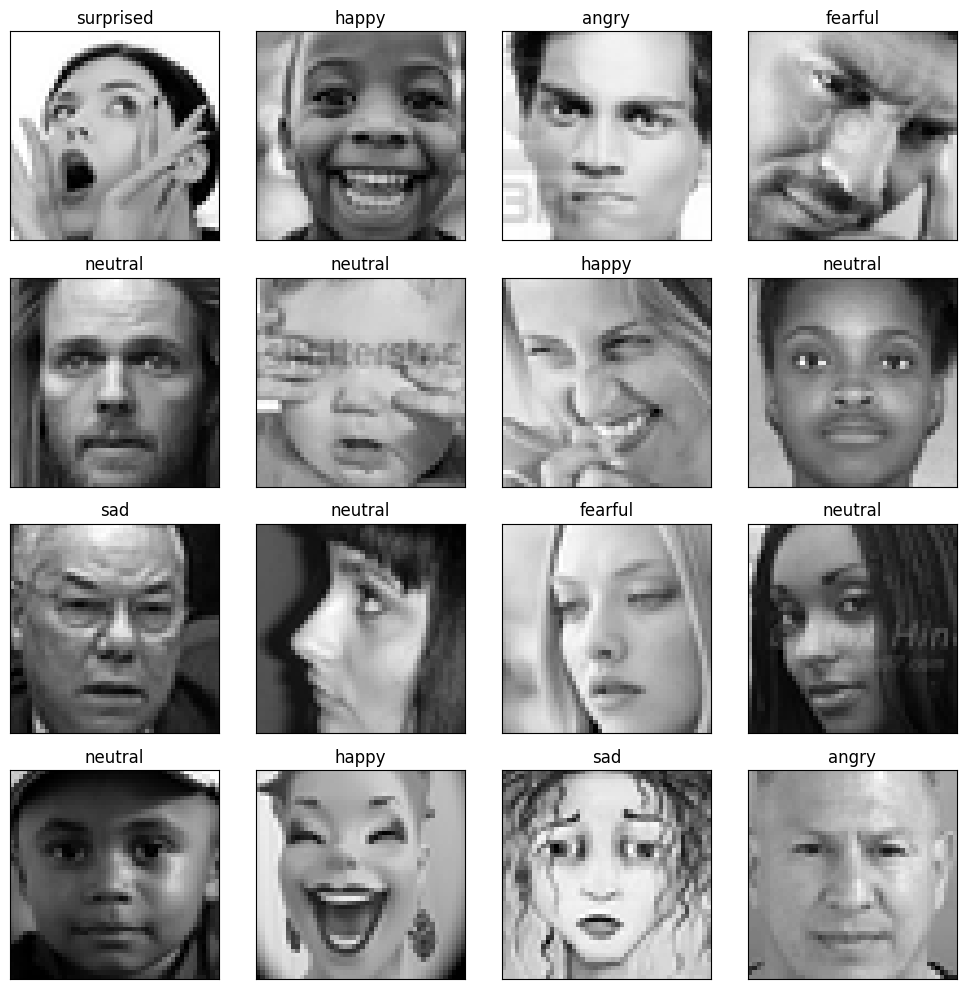

In [9]:
random_index = np.random.randint(0, len(train_dataset), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    filepath, label_idx = train_dataset.samples[random_index[i]]
    
    image = plt.imread(filepath)
    
    ax.imshow(image, cmap='gray')
    
    ax.set_title(train_dataset.classes[label_idx])

plt.tight_layout()
plt.show()


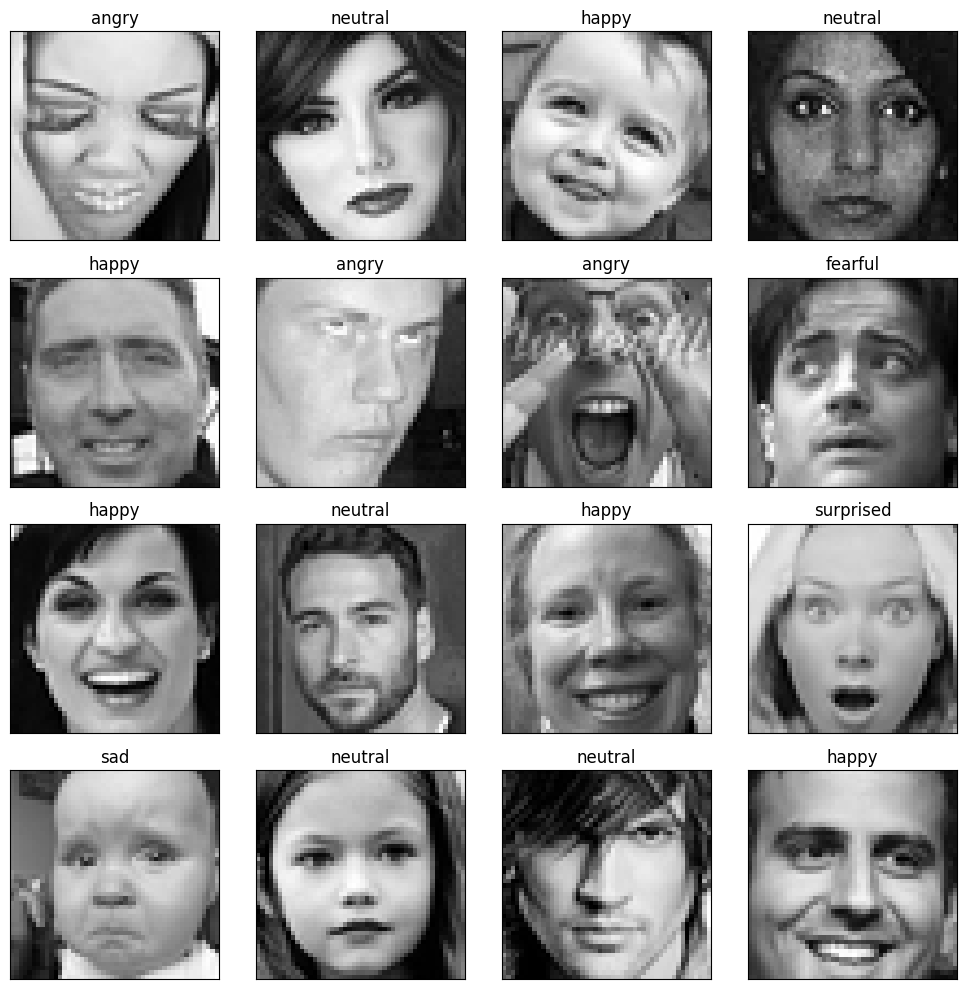

In [10]:
random_index = np.random.randint(0, len(test_dataset), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    filepath, label_idx = test_dataset.samples[random_index[i]]
    
    image = plt.imread(filepath)
    
    ax.imshow(image, cmap='gray')
    
    ax.set_title(test_dataset.classes[label_idx])

plt.tight_layout()
plt.show()

### Create DataLoader

In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Create Model

In [16]:
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True, num_classes=7)
model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

### Lost Function

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reduce ir
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True)

# Set Early Stopping and Best Model Saving
patience = 3
patience_counter = 0
best_val_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# metric for plot
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Train One Epoch Function

In [18]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

### Evaluate Function (Loss, Accuracy and F1 Score)

In [19]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_acc, epoch_f1

### Model Train

In [20]:
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    # Improve learning rate form validation F1 score
    scheduler.step(val_f1)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

    # Best Model Save (validation F1 score)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_efficientnet.pth")
        print("  Best model saved.")
        patience_counter = 0  # reset counter
    else:
        patience_counter += 1

    # not improve epoch stop train
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Load Best Model
model.load_state_dict(best_model_wts)

Epoch [1/30]
  Train Loss: 1.2257 | Train Acc: 55.84%
  Val Loss: 1.0331 | Val Acc: 61.69% | Val F1: 0.5989
  Best model saved.
Epoch [2/30]
  Train Loss: 0.9394 | Train Acc: 64.92%
  Val Loss: 0.9899 | Val Acc: 63.58% | Val F1: 0.6244
  Best model saved.
Epoch [3/30]
  Train Loss: 0.8361 | Train Acc: 68.98%
  Val Loss: 1.0199 | Val Acc: 62.64% | Val F1: 0.6218
Epoch [4/30]
  Train Loss: 0.7446 | Train Acc: 72.44%
  Val Loss: 0.9811 | Val Acc: 65.63% | Val F1: 0.6562
  Best model saved.
Epoch [5/30]
  Train Loss: 0.6529 | Train Acc: 75.99%
  Val Loss: 1.0262 | Val Acc: 65.53% | Val F1: 0.6515
Epoch [6/30]
  Train Loss: 0.5584 | Train Acc: 79.55%
  Val Loss: 1.0277 | Val Acc: 66.05% | Val F1: 0.6573
  Best model saved.
Epoch [7/30]
  Train Loss: 0.4566 | Train Acc: 83.19%
  Val Loss: 1.1373 | Val Acc: 65.99% | Val F1: 0.6592
  Best model saved.
Epoch [8/30]
  Train Loss: 0.3772 | Train Acc: 86.49%
  Val Loss: 1.1733 | Val Acc: 64.21% | Val F1: 0.6438
Epoch [9/30]
  Train Loss: 0.3011 | 

<All keys matched successfully>

In [23]:
torch.save(model.state_dict(), "best_efficientnet_model.pth")

### Graph

In [24]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(18,5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

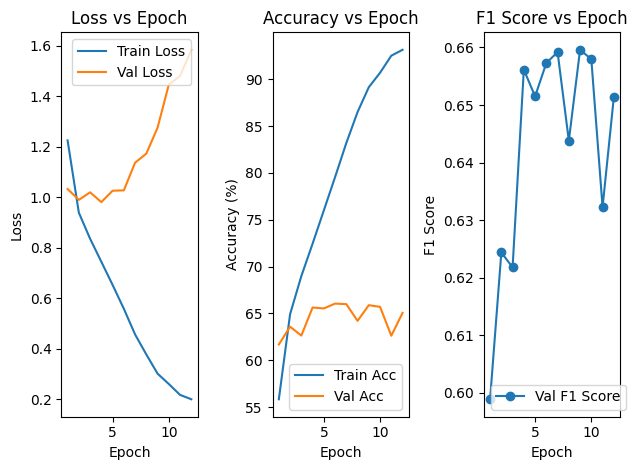

In [25]:
plt.subplot(1,3,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs_range, val_f1s, label="Val F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

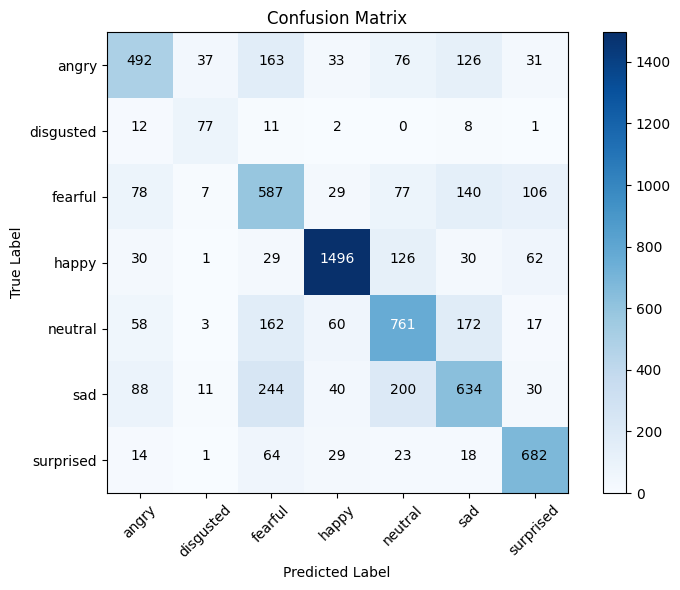

In [26]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

classes = train_dataset.classes

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Predicted Validation

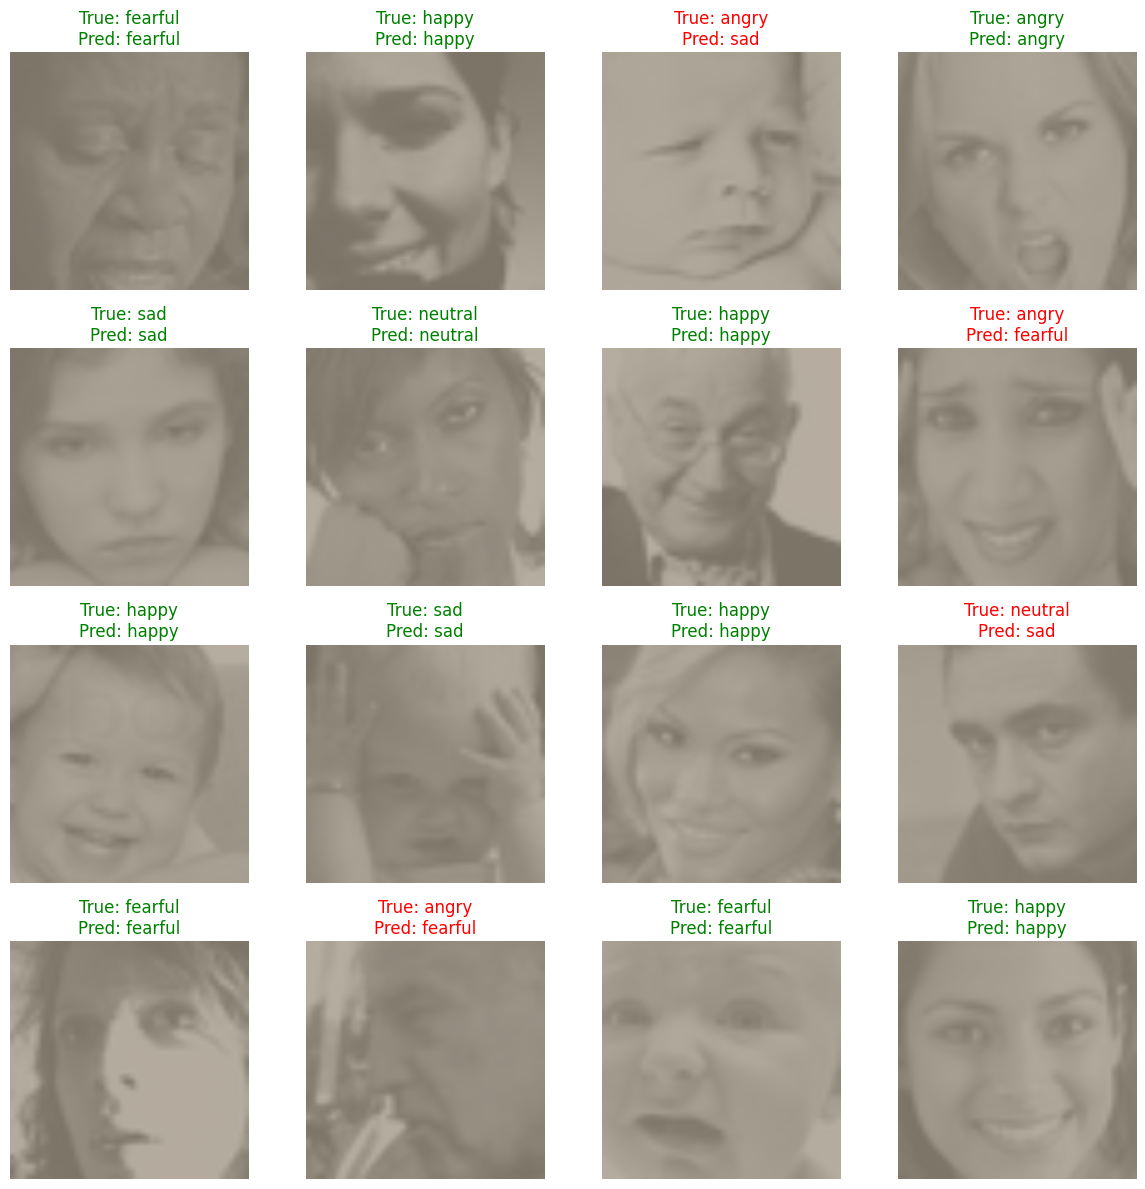

In [27]:
num_samples = 16
indices = np.random.choice(len(test_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    true_label = test_dataset.classes[label]
    pred_label = test_dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

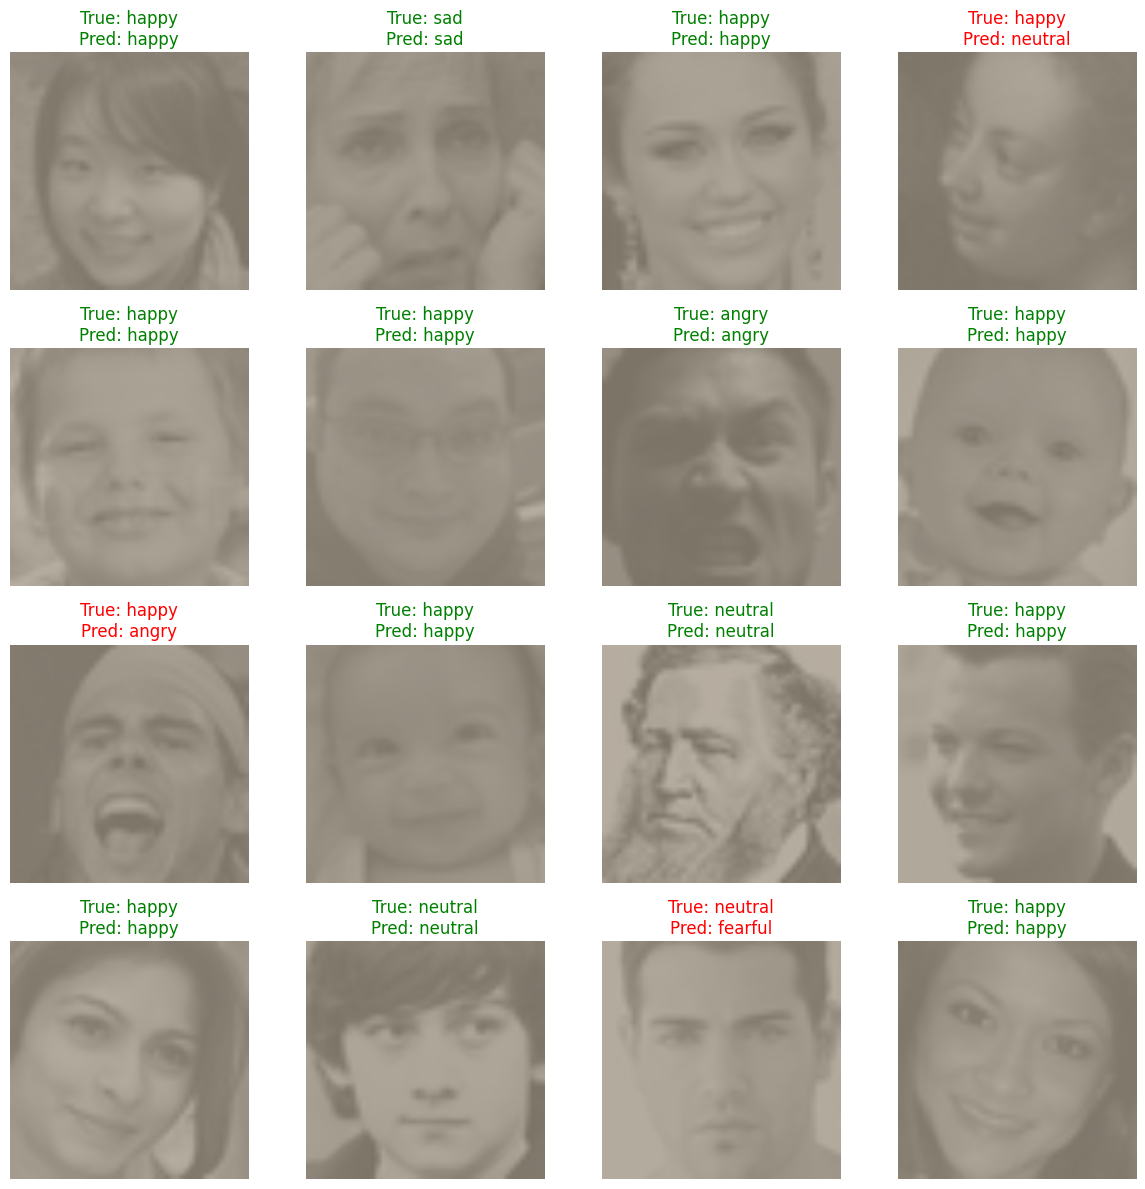

In [28]:
num_samples = 16
indices = np.random.choice(len(test_dataset), size=num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    outputs = model(image_tensor)
    _, pred = torch.max(outputs, 1)
    pred = pred.item()
    
    # Inverse normalization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    ax = axes.flat[i]
    ax.imshow(image_np)
    
    color = 'green' if pred == label else 'red'
    
    true_label = test_dataset.classes[label]
    pred_label = test_dataset.classes[pred]
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()